In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Preprocessing Datasets

In [309]:
#Pre-processes dataset and splits it into train and test-set in 8:2 ratio
def preprocessing(df, y_label):
    '''

    Parameters:
        df: pandas dataframe
        y_label: str
    Returns:
        Xtrain: np.ndarray
        Ytrain: np.ndarray
        Xtest: np.ndarray
        Ytest: np.ndarray

    '''

    #Get all columns with exactly two unique non-numeric values
    cols_with_two_unique_values = [col for col in df.columns if df[col].nunique(dropna=False) == 2 and not pd.api.types.is_numeric_dtype(df[col])]

    #replacing unique values with 0s and 1s in such columns (this can reduce unnecessary columns after one-hot encoding classification datasets)
    for col in cols_with_two_unique_values:
        values = df[col].unique()
        df[col] = df[col].replace({values[0]: 0, values[1]: 1})

    #One-hot encoding remaining non-numeric columns and replace boolean values with binary values
    df = pd.get_dummies(df).replace({False: 0, True: 1})

    #Drop rows with missing values (if any)
    df = df.dropna()

    #Normalize data
    df = (df - df.min()) / (df.max() - df.min())


    #split into train and test set
    df_train = df.sample(frac=0.8, axis=0)
    df_test = df.drop(df_train.index)

    #Choose target feature
    y_train = df_train[f'{y_label}'].to_numpy()
    X_train = df_train.drop(columns=[f'{y_label}']).to_numpy()

    y_test = df_test[f'{y_label}'].to_numpy()
    X_test = df_test.drop(columns=[f'{y_label}']).to_numpy()

    return X_train, y_train, X_test, y_test

In [310]:
#Reading marketing dataset
marketing_df = pd.read_csv('bank+marketing/bank/bank.csv', sep=';')
#Preprocess data
Xtrain_marketing, ytrain_marketing, Xtest_marketing, ytest_marketing = preprocessing(marketing_df, y_label='y')


#Reading wine datasets
df_wine = pd.read_csv('winequality-red.csv', sep=';')

#df_wine_red = pd.read_csv('winequality-red.csv', sep=';')
#df_wine_white = pd.read_csv('winequality-white.csv', sep=';')

#Label wine type and concat datasets
#df_wine_red['Wine'] = 'Red'
#df_wine_white['Wine'] = 'White'
#df_wine = pd.concat([df_wine_red, df_wine_white], axis=0)

#Preprocess data
Xtrain_wine, ytrain_wine, Xtest_wine, ytest_wine = preprocessing(df_wine, y_label='quality')


/tmp/ipykernel_3916/1731962100.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({values[0]: 0, values[1]: 1})
/tmp/ipykernel_3916/1731962100.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.get_dummies(df).replace({False: 0, True: 1})


# Regularization

In [311]:
#function to shuffle data
def shuffle_data(X, y):
    assert len(X) == len(y), "X and y must have the same number of samples"
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], y[indices]

def adagrad_steplength(gradient, h_sum, mu_0, epsilon=1e-8):
    """
    Adagrad stepsize update.

    Parameters:
        gradient (np.array): Current gradient vector (n,)
        h (np.array): Accumulated squared gradients (historical sum), shape (n,)
        mu_0 (np.araray): Initial learning rate (μ₀)
        epsilon (float): Small constant to prevent division by zero

    Returns:
        mu (np.array): Adjusted stepsizes for each parameter
        h_new (np.array): Updated historical sum of squared gradients
    """

    h_sum += np.power(gradient, 2)
    mu = mu_0/np.sqrt(h_sum + epsilon)
    return mu, h_sum


def mbgd (X_train, y_train, loss, gradient, beta, learning_rate, i_max, eps, batch_size):

    loss_changes = []
    beta_values = [beta]

    #initialization for adagrad
    #h_sum = np.zeros(X_train.shape[1])


    for i in range(i_max):

        X_train_shuffled, y_train_shuffled = shuffle_data(X_train, y_train)


        for start in range(0, len(X_train_shuffled), batch_size):

            #for start of each batch calculate end
            end = min(start + batch_size, len(X_train_shuffled))
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]

            g = gradient(beta, X_batch, y_batch)

            #calculate learning rate using adagrad
            #learning_rate, h_sum = adagrad_steplength(g, h_sum, mu_0=learning_rate)

            loss_before_update = loss(beta, X_batch, y_batch)
            beta = beta - learning_rate * g
            loss_after_update = loss(beta, X_batch, y_batch)

            loss_change = abs(loss_before_update - loss_after_update)
            loss_changes.append(loss_change)

            if loss_change < eps:
                return beta_values, loss_changes

        #record beta after each epoch
        beta_values.append(beta)

    #print(f"No convergence in {i_max} epochs")
    return beta_values, loss_changes



def linear_regression_with_regularization(X_train, y_train, reg_const, learning_rate, i_max, eps):

    #Initial value for beta
    beta_0 = np.zeros(X_train.shape[1])

    #loss function
    def loss(beta, X, y):
        return (y - X @ beta).T @ (y - X @ beta) + reg_const * (beta.T @ beta)

    #Gradient of loss function w.r.t. beta
    def gradient(beta, X, y):
        return 2 * X.T @ (X @ beta - y) + (2 * reg_const * beta)

    return mbgd(X_train, y_train, loss, gradient, beta_0, learning_rate, i_max, eps, batch_size= 50)

def calculate_rmse(beta, X, y):

    #predict target value using computed beta
    y_hat = X @ beta
    #find rmse compared to true target value
    rmse = np.sqrt(((y - y_hat) ** 2).mean())
    return rmse


def logistic_regression_with_regularization(X_train, y_train, reg_const, learning_rate, i_max, eps):

    #Initial value for beta
    beta_0 = np.zeros(X_train.shape[1])

    #https://staff.fnwi.uva.nl/r.vandenboomgaard/MachineLearning/LectureNotes/Classification/LogisticRegression/LogRegrVectorized.html
    #loss function
    def loss(beta, X, y):
        z = X @ beta
        return np.mean(np.logaddexp(0, z) - y * z) + reg_const * (beta.T @ beta)

    #Gradient of loss function w.r.t. beta
    def gradient(beta, X, y):
        z = X @ beta
        z = np.clip(z, -500, 500)
        p = 1 / (1 + np.exp(-z))
        # Clip probabilities to avoid log(0)
        p = np.clip(p, 1e-15, 1 - 1e-15)

        return (X.T @ (p - y))/len(y) + (2 * reg_const * beta)

    return mbgd(X_train, y_train, loss, gradient, beta_0, learning_rate, i_max, eps, batch_size= 50)


def calculate_log_loss(beta, X, y):

    #compute predictions using test set
    z = X @ beta
    p = 1 / (1 + np.exp(-z))

    # Clip probabilities to avoid log(0)
    eps = 1e-15
    p = np.clip(p, eps, 1 - eps)

    #calculate log-loss
    return - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))


Ridge regression on wine dataset

In [312]:
alpha1 = 1e-6
alpha2 = 1e-4
alpha3 = 1e-2

reg_const1 = 1e-4
reg_const2 = 0.1
reg_const3 = 10

eps = 1e-8
i_max = 500

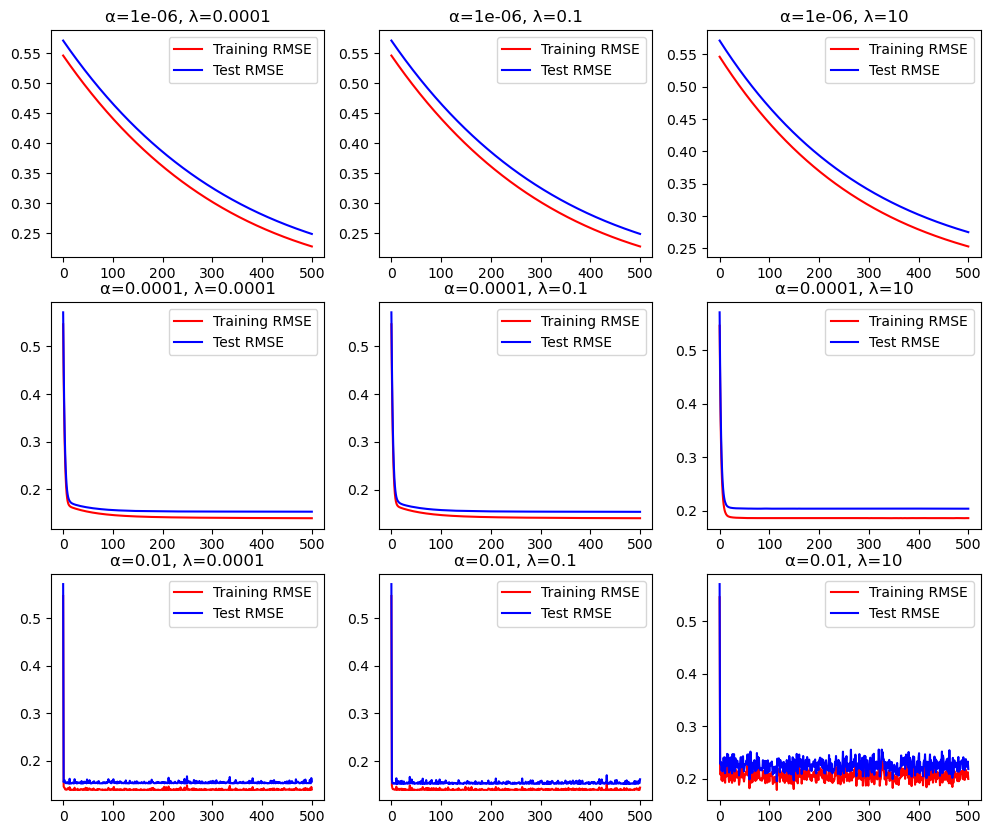

In [313]:
#subplots for each combination of alpha and reg_const
fig, axes = plt.subplots(3, 3, figsize=(12,10))


#alpha1, reg_const1
beta_values, loss_changes = linear_regression_with_regularization(Xtrain_wine, ytrain_wine, reg_const1, alpha1, i_max, eps=eps)
RMSE_training = [calculate_rmse(beta, Xtrain_wine, ytrain_wine) for beta in beta_values]
RMSE_test = [calculate_rmse(beta, Xtest_wine, ytest_wine) for beta in beta_values]

axes[0,0].plot(RMSE_training, label="Training RMSE", color="red")
axes[0,0].plot(RMSE_test, label="Test RMSE", color="blue")
axes[0,0].set_title(f"α={alpha1}, λ={reg_const1}")
axes[0,0].legend()


#alpha1, reg_const2
beta_values, loss_changes = linear_regression_with_regularization(Xtrain_wine, ytrain_wine, reg_const2, alpha1, i_max, eps=eps)
RMSE_training = [calculate_rmse(beta, Xtrain_wine, ytrain_wine) for beta in beta_values]
RMSE_test = [calculate_rmse(beta, Xtest_wine, ytest_wine) for beta in beta_values]

axes[0,1].plot(RMSE_training, label="Training RMSE", color="red")
axes[0,1].plot(RMSE_test, label="Test RMSE", color="blue")
axes[0,1].set_title(f"α={alpha1}, λ={reg_const2}")
axes[0,1].legend()

#alpha1, reg_const3
beta_values, loss_changes = linear_regression_with_regularization(Xtrain_wine, ytrain_wine, reg_const3, alpha1, i_max, eps=eps)
RMSE_training = [calculate_rmse(beta, Xtrain_wine, ytrain_wine) for beta in beta_values]
RMSE_test = [calculate_rmse(beta, Xtest_wine, ytest_wine) for beta in beta_values]

axes[0,2].plot(RMSE_training, label="Training RMSE", color="red")
axes[0,2].plot(RMSE_test, label="Test RMSE", color="blue")
axes[0,2].set_title(f"α={alpha1}, λ={reg_const3}")
axes[0,2].legend()



#alpha2, reg_const1
beta_values, loss_changes = linear_regression_with_regularization(Xtrain_wine, ytrain_wine, reg_const1, alpha2, i_max, eps=eps)
RMSE_training = [calculate_rmse(beta, Xtrain_wine, ytrain_wine) for beta in beta_values]
RMSE_test = [calculate_rmse(beta, Xtest_wine, ytest_wine) for beta in beta_values]

axes[1,0].plot(RMSE_training, label="Training RMSE", color="red")
axes[1,0].plot(RMSE_test, label="Test RMSE", color="blue")
axes[1,0].set_title(f"α={alpha2}, λ={reg_const1}")
axes[1,0].legend()


#alpha2, reg_const2
beta_values, loss_changes = linear_regression_with_regularization(Xtrain_wine, ytrain_wine, reg_const2, alpha2, i_max, eps=eps)
RMSE_training = [calculate_rmse(beta, Xtrain_wine, ytrain_wine) for beta in beta_values]
RMSE_test = [calculate_rmse(beta, Xtest_wine, ytest_wine) for beta in beta_values]

axes[1,1].plot(RMSE_training, label="Training RMSE", color="red")
axes[1,1].plot(RMSE_test, label="Test RMSE", color="blue")
axes[1,1].set_title(f"α={alpha2}, λ={reg_const2}")
axes[1,1].legend()

#alpha2, reg_const3
beta_values, loss_changes = linear_regression_with_regularization(Xtrain_wine, ytrain_wine, reg_const3, alpha2, i_max, eps=eps)
RMSE_training = [calculate_rmse(beta, Xtrain_wine, ytrain_wine) for beta in beta_values]
RMSE_test = [calculate_rmse(beta, Xtest_wine, ytest_wine) for beta in beta_values]

axes[1,2].plot(RMSE_training, label="Training RMSE", color="red")
axes[1,2].plot(RMSE_test, label="Test RMSE", color="blue")
axes[1,2].set_title(f"α={alpha2}, λ={reg_const3}")
axes[1,2].legend()




#alpha3, reg_const1
beta_values, loss_changes = linear_regression_with_regularization(Xtrain_wine, ytrain_wine, reg_const1, alpha3, i_max, eps=eps)
RMSE_training = [calculate_rmse(beta, Xtrain_wine, ytrain_wine) for beta in beta_values]
RMSE_test = [calculate_rmse(beta, Xtest_wine, ytest_wine) for beta in beta_values]

axes[2,0].plot(RMSE_training, label="Training RMSE", color="red")
axes[2,0].plot(RMSE_test, label="Test RMSE", color="blue")
axes[2,0].set_title(f"α={alpha3}, λ={reg_const1}")
axes[2,0].legend()


#alpha3, reg_const2
beta_values, loss_changes = linear_regression_with_regularization(Xtrain_wine, ytrain_wine, reg_const2, alpha3, i_max, eps=eps)
RMSE_training = [calculate_rmse(beta, Xtrain_wine, ytrain_wine) for beta in beta_values]
RMSE_test = [calculate_rmse(beta, Xtest_wine, ytest_wine) for beta in beta_values]

axes[2,1].plot(RMSE_training, label="Training RMSE", color="red")
axes[2,1].plot(RMSE_test, label="Test RMSE", color="blue")
axes[2,1].set_title(f"α={alpha3}, λ={reg_const2}")
axes[2,1].legend()

#alpha3, reg_const3
beta_values, loss_changes = linear_regression_with_regularization(Xtrain_wine, ytrain_wine, reg_const3, alpha3, i_max, eps=eps)
RMSE_training = [calculate_rmse(beta, Xtrain_wine, ytrain_wine) for beta in beta_values]
RMSE_test = [calculate_rmse(beta, Xtest_wine, ytest_wine) for beta in beta_values]

axes[2,2].plot(RMSE_training, label="Training RMSE", color="red")
axes[2,2].plot(RMSE_test, label="Test RMSE", color="blue")
axes[2,2].set_title(f"α={alpha3}, λ={reg_const3}")
axes[2,2].legend()





Logistic regression with regularization for Marketing dataset

In [314]:
alpha1 = 1e-6
alpha2 = 1e-4
alpha3 = 1e-2

reg_const1 = 1e-4
reg_const2 = 0.1
reg_const3 = 10

eps = 1e-8
i_max = 500

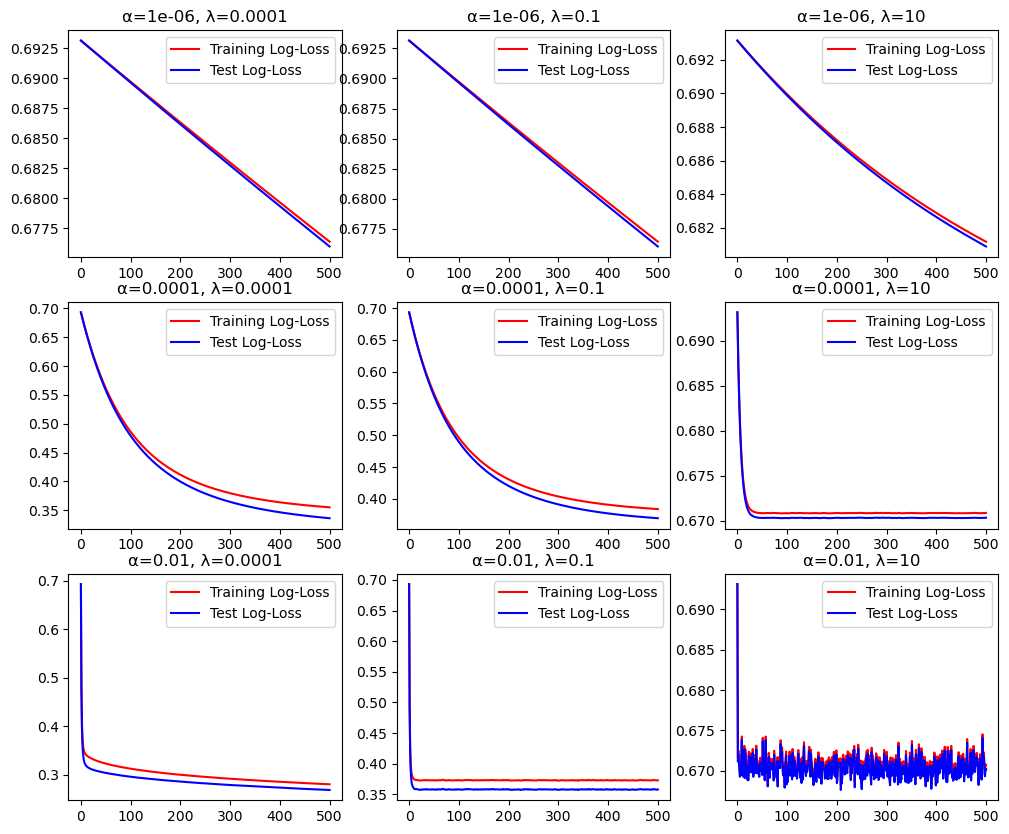

In [328]:
#subplots for each combination of alpha and reg_const
fig, axes = plt.subplots(3, 3, figsize=(12,10))


#alpha1, reg_const1
beta_values, loss_changes = logistic_regression_with_regularization(Xtrain_marketing, ytrain_marketing, reg_const1, alpha1, i_max, eps=eps)
logloss_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
logloss_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]



axes[0,0].plot(logloss_training, label="Training Log-Loss", color="red")
axes[0,0].plot(logloss_test, label="Test Log-Loss", color="blue")
axes[0,0].set_title(f"α={alpha1}, λ={reg_const1}")
axes[0,0].legend()


#alpha1, reg_const2
beta_values, loss_changes = logistic_regression_with_regularization(Xtrain_marketing, ytrain_marketing, reg_const2, alpha1, i_max, eps=eps)
logloss_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
logloss_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[0,1].plot(logloss_training, label="Training Log-Loss", color="red")
axes[0,1].plot(logloss_test, label="Test Log-Loss", color="blue")
axes[0,1].set_title(f"α={alpha1}, λ={reg_const2}")
axes[0,1].legend()

#alpha1, reg_const3
beta_values, loss_changes = logistic_regression_with_regularization(Xtrain_marketing, ytrain_marketing, reg_const3, alpha1, i_max, eps=eps)
logloss_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
logloss_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[0,2].plot(logloss_training, label="Training Log-Loss", color="red")
axes[0,2].plot(logloss_test, label="Test Log-Loss", color="blue")
axes[0,2].set_title(f"α={alpha1}, λ={reg_const3}")
axes[0,2].legend()



#alpha2, reg_const1
beta_values, loss_changes = logistic_regression_with_regularization(Xtrain_marketing, ytrain_marketing, reg_const1, alpha2, i_max, eps=eps)
logloss_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
logloss_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[1,0].plot(logloss_training, label="Training Log-Loss", color="red")
axes[1,0].plot(logloss_test, label="Test Log-Loss", color="blue")
axes[1,0].set_title(f"α={alpha2}, λ={reg_const1}")
axes[1,0].legend()


#alpha2, reg_const2
beta_values, loss_changes = logistic_regression_with_regularization(Xtrain_marketing, ytrain_marketing, reg_const2, alpha2, i_max, eps=eps)
logloss_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
logloss_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[1,1].plot(logloss_training, label="Training Log-Loss", color="red")
axes[1,1].plot(logloss_test, label="Test Log-Loss", color="blue")
axes[1,1].set_title(f"α={alpha2}, λ={reg_const2}")
axes[1,1].legend()

#alpha2, reg_const3
beta_values, loss_changes = logistic_regression_with_regularization(Xtrain_marketing, ytrain_marketing, reg_const3, alpha2, i_max, eps=eps)
logloss_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
logloss_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[1,2].plot(logloss_training, label="Training Log-Loss", color="red")
axes[1,2].plot(logloss_test, label="Test Log-Loss", color="blue")
axes[1,2].set_title(f"α={alpha2}, λ={reg_const3}")
axes[1,2].legend()




#alpha3, reg_const1
beta_values, loss_changes = logistic_regression_with_regularization(Xtrain_marketing, ytrain_marketing, reg_const1, alpha3, i_max, eps=eps)
logloss_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
logloss_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[2,0].plot(logloss_training, label="Training Log-Loss", color="red")
axes[2,0].plot(logloss_test, label="Test Log-Loss", color="blue")
axes[2,0].set_title(f"α={alpha3}, λ={reg_const1}")
axes[2,0].legend()


#alpha3, reg_const2
beta_values, loss_changes = logistic_regression_with_regularization(Xtrain_marketing, ytrain_marketing, reg_const2, alpha3, i_max, eps=eps)
logloss_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
logloss_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[2,1].plot(logloss_training, label="Training Log-Loss", color="red")
axes[2,1].plot(logloss_test, label="Test Log-Loss", color="blue")
axes[2,1].set_title(f"α={alpha3}, λ={reg_const2}")
axes[2,1].legend()

#alpha3, reg_const3
beta_values, loss_changes = logistic_regression_with_regularization(Xtrain_marketing, ytrain_marketing, reg_const3, alpha3, i_max, eps=eps)
logloss_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
logloss_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[2,2].plot(logloss_training, label="Training Log-Loss", color="red")
axes[2,2].plot(logloss_test, label="Test Log-Loss", color="blue")
axes[2,2].set_title(f"α={alpha3}, λ={reg_const3}")
axes[2,2].legend()







# Hyper-parameter Tuning

In [316]:
#Function to split data into k folds. Returns a list of tuples containing split indices for training and validation
def k_fold_split (total_samples, k):


    indices = np.arange(total_samples)
    np.random.shuffle(indices)
    fold_sizes = np.full(k, total_samples // k)
    fold_sizes[:total_samples % k] += 1

    current = 0
    #array to hold training and validation indices of folds
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = indices[start:stop]
        train_idx = np.concatenate((indices[:start], indices[stop:]))
        folds.append((train_idx, val_idx))
        current = stop
    return folds


def grid_search (X, y, alphas, lambdas, k, model_type, i_max, eps):

    performance_grid = np.zeros((len(alphas), len(lambdas)))

    folds = k_fold_split(len(X), k)

    for i, alpha in enumerate(alphas):
        for j, lam in enumerate(lambdas):

            val_errors = []

            #goes through each fold and calculates performance of lambda and alpha
            for train_idx, val_idx in folds:
                X_train_fold, y_train_fold = X[train_idx], y[train_idx]
                X_val_fold, y_val_fold = X[val_idx], y[val_idx]

                if model_type == "linear":
                    beta_values, _ = linear_regression_with_regularization(
                        X_train_fold, y_train_fold, lam, alpha, i_max, eps
                    )
                    beta_final = beta_values[-1]
                    val_error = calculate_rmse(beta_final, X_val_fold, y_val_fold)

                elif model_type == "logistic":
                    beta_values, _ = logistic_regression_with_regularization(
                        X_train_fold, y_train_fold, lam, alpha, i_max, eps
                    )
                    beta_final = beta_values[-1]
                    val_error = calculate_log_loss(beta_final, X_val_fold, y_val_fold)

                else:
                    raise ValueError("model_type must be 'linear' or 'logistic'")

                val_errors.append(val_error)

            performance_grid[i, j] = np.mean(val_errors)

    # Find best hyperparameters
    best_idx = np.unravel_index(np.argmin(performance_grid), performance_grid.shape)
    best_alpha = alphas[best_idx[0]]
    best_lambda = lambdas[best_idx[1]]


    return best_alpha, best_lambda, performance_grid


In [323]:
alpha_vals = [1e-6, 1e-5, 5e-4, 1e-3, 5e-3]
lambda_vals = [0.0001, 0.001, 0.01, 0.1, 1.0]

eps = 1e-8
i_max = 500

Performing grid-search with cross validation on the wine dataset

Alpha: 0.000001, Lambda: 0.000100 => Validation Error: 0.229393
Alpha: 0.000001, Lambda: 0.001000 => Validation Error: 0.229396
Alpha: 0.000001, Lambda: 0.010000 => Validation Error: 0.229419
Alpha: 0.000001, Lambda: 0.100000 => Validation Error: 0.229656
Alpha: 0.000001, Lambda: 1.000000 => Validation Error: 0.232020
Alpha: 0.000010, Lambda: 0.000100 => Validation Error: 0.155308
Alpha: 0.000010, Lambda: 0.001000 => Validation Error: 0.155309
Alpha: 0.000010, Lambda: 0.010000 => Validation Error: 0.155323
Alpha: 0.000010, Lambda: 0.100000 => Validation Error: 0.155458
Alpha: 0.000010, Lambda: 1.000000 => Validation Error: 0.157083
Alpha: 0.000500, Lambda: 0.000100 => Validation Error: 0.142869
Alpha: 0.000500, Lambda: 0.001000 => Validation Error: 0.142873
Alpha: 0.000500, Lambda: 0.010000 => Validation Error: 0.142898
Alpha: 0.000500, Lambda: 0.100000 => Validation Error: 0.143004
Alpha: 0.000500, Lambda: 1.000000 => Validation Error: 0.148216
Alpha: 0.001000, Lambda: 0.000100 => Val

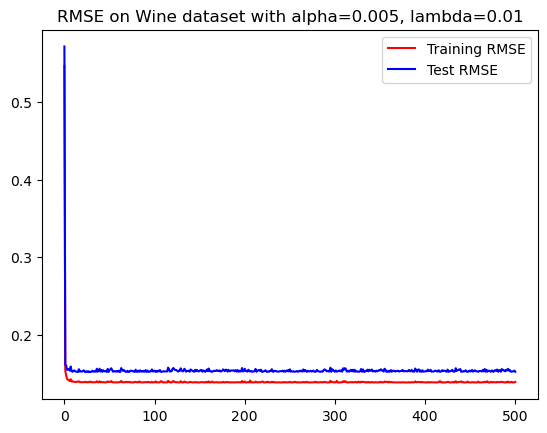

In [326]:
X_wine = X = np.concatenate([Xtrain_wine, Xtest_wine], axis=0)
y_wine = np.concatenate([ytrain_wine, ytest_wine], axis=0)

best_alpha, best_lambda, performance_grid = grid_search(X_wine, y_wine, alpha_vals, lambda_vals, 5, 'linear', i_max, eps)

for i, alpha in enumerate(alpha_vals):
    for j, lambd in enumerate(lambda_vals):
        error = performance_grid[i, j]
        print(f"Alpha: {alpha:.6f}, Lambda: {lambd:.6f} => Validation Error: {error:.6f}")

print("Best alpha for wine dataset:", best_alpha)
print("Best lambda for wine dataset:", best_lambda)



beta_values, _ = linear_regression_with_regularization(Xtrain_wine, ytrain_wine, best_lambda, best_alpha, i_max, eps)

#Parameter beta
RMSE_training = [calculate_rmse(beta, Xtrain_wine, ytrain_wine) for beta in beta_values]
RMSE_test = [calculate_rmse(beta, Xtest_wine, ytest_wine) for beta in beta_values]


plt.plot(RMSE_training, label="Training RMSE", color="red")
plt.plot(RMSE_test, label="Test RMSE", color="blue")
plt.title(f"RMSE on Wine dataset with alpha={best_alpha}, lambda={best_lambda}")
plt.legend()
plt.show()

Grid-search and Cross-validation allows us to find the best Hyperparameters

Now, performing the same on Marketing dataset

Alpha: 0.000001, Lambda: 0.000100 => Validation Error: 0.676231
Alpha: 0.000001, Lambda: 0.001000 => Validation Error: 0.676231
Alpha: 0.000001, Lambda: 0.010000 => Validation Error: 0.676237
Alpha: 0.000001, Lambda: 0.100000 => Validation Error: 0.676292
Alpha: 0.000001, Lambda: 1.000000 => Validation Error: 0.676822
Alpha: 0.000010, Lambda: 0.000100 => Validation Error: 0.560453
Alpha: 0.000010, Lambda: 0.001000 => Validation Error: 0.560483
Alpha: 0.000010, Lambda: 0.010000 => Validation Error: 0.560845
Alpha: 0.000010, Lambda: 0.100000 => Validation Error: 0.564348
Alpha: 0.000010, Lambda: 1.000000 => Validation Error: 0.593637
Alpha: 0.000500, Lambda: 0.000100 => Validation Error: 0.328882
Alpha: 0.000500, Lambda: 0.001000 => Validation Error: 0.329093
Alpha: 0.000500, Lambda: 0.010000 => Validation Error: 0.331802
Alpha: 0.000500, Lambda: 0.100000 => Validation Error: 0.369586
Alpha: 0.000500, Lambda: 1.000000 => Validation Error: 0.545259
Alpha: 0.001000, Lambda: 0.000100 => Val

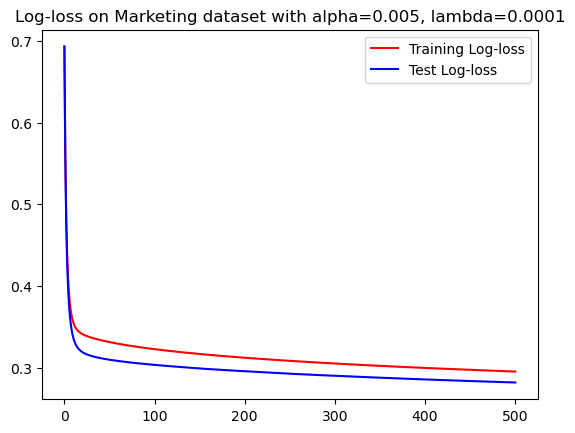

In [327]:
X_marketing = X = np.concatenate([Xtrain_marketing, Xtest_marketing], axis=0)
y_marketing = np.concatenate([ytrain_marketing, ytest_marketing], axis=0)

best_alpha, best_lambda, performance_grid = grid_search(X_marketing, y_marketing, alpha_vals, lambda_vals, 5, 'logistic', i_max, eps)

for i, alpha in enumerate(alpha_vals):
    for j, lambd in enumerate(lambda_vals):
        error = performance_grid[i, j]
        print(f"Alpha: {alpha:.6f}, Lambda: {lambd:.6f} => Validation Error: {error:.6f}")

print("Best alpha for marketing dataset:", best_alpha)
print("Best lambda for marketing dataset:", best_lambda)


#Training using best alpha and lambda
beta_values, _ = logistic_regression_with_regularization(Xtrain_marketing, ytrain_marketing, best_lambda, best_alpha, i_max, eps)

#Parameter beta
logloss_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
logloss_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]


plt.plot(logloss_training, label="Training Log-loss", color="red")
plt.plot(logloss_test, label="Test Log-loss", color="blue")
plt.title(f"Log-loss on Marketing dataset with alpha={best_alpha}, lambda={best_lambda}")
plt.legend()
plt.show()

# Newton's Method

In [320]:
def minimize_newton (X_train, y_train, loss, gradient, hessian, beta, learning_rate, reg_const, i_max, eps, batch_size):

    loss_changes = []
    beta_values = [beta]

    #initialization for adagrad
    h_sum = np.zeros(X_train.shape[1])


    for i in range(i_max):

        X_train_shuffled, y_train_shuffled = shuffle_data(X_train, y_train)


        for start in range(0, len(X_train_shuffled), batch_size):

            #for start of each batch calculate end
            end = min(start + batch_size, len(X_train_shuffled))
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]

            g = gradient(beta, X_batch, y_batch)
            H = hessian(beta, X_batch, y_batch)

            #calculate learning rate using adagrad
            #learning_rate, h_sum = adagrad_steplength(g, h_sum, mu_0=learning_rate)

            loss_before_update = loss(beta, X_batch, y_batch)

            update = np.linalg.solve(H, g)
            beta = beta - learning_rate * update

            loss_after_update = loss(beta, X_batch, y_batch)

            loss_change = abs(loss_before_update - loss_after_update)
            loss_changes.append(loss_change)

            if loss_change < eps:
                return beta_values, loss_changes

        #record beta after each epoch
        beta_values.append(beta)

    #print(f"No convergence in {i_max} epochs")
    return beta_values, loss_changes




def learn_logreg_newton (Xtrain, ytrain, reg_const, learning_rate, i_max, eps):

    beta_0 = np.zeros(Xtrain.shape[1])

    def loss(beta, X, y):
        z = X @ beta
        #p = 1 / (1 + np.exp(-z))
        # Clip probabilities to avoid log(0)
        #eps = 1e-15
        #p = np.clip(p, eps, 1 - eps)
        #return (-y.T @ np.log(p) - (1 - y).T @ np.log(1 - p))/len(y) + reg_const * (beta.T @ beta)
        return np.mean(np.logaddexp(0, z) - y * z) + reg_const * (beta.T @ beta)

    #Gradient of loss function w.r.t. beta
    def gradient(beta, X, y):
        z = X @ beta
        z = np.clip(z, -500, 500)
        p = 1 / (1 + np.exp(-z))
        # Clip probabilities to avoid log(0)
        eps = 1e-15
        p = np.clip(p, eps, 1 - eps)

        return (X.T @ (p - y))/len(y) + (2 * reg_const * beta)


    def hessian(beta, X, y):
        z = X @ beta
        p = 1 / (1 + np.exp(-z))
        s = p * (1 - p)
        S = np.diag(s)

        H = (X.T @ S @ X) / len(y)

        # L2 regularization
        R = np.eye(len(beta))

        H += 2 * reg_const * R

        return H

    return minimize_newton(Xtrain, ytrain, loss, gradient, hessian, beta_0, learning_rate, reg_const, i_max, eps, batch_size=50)


In [321]:
alpha1 = 1e-6
alpha2 = 1e-4
alpha3 = 1e-2

reg_const1 = 1e-4
reg_const2 = 0.1
reg_const3 = 10

eps = 1e-8
i_max = 500

Training the model with marketing dataset using newton's method

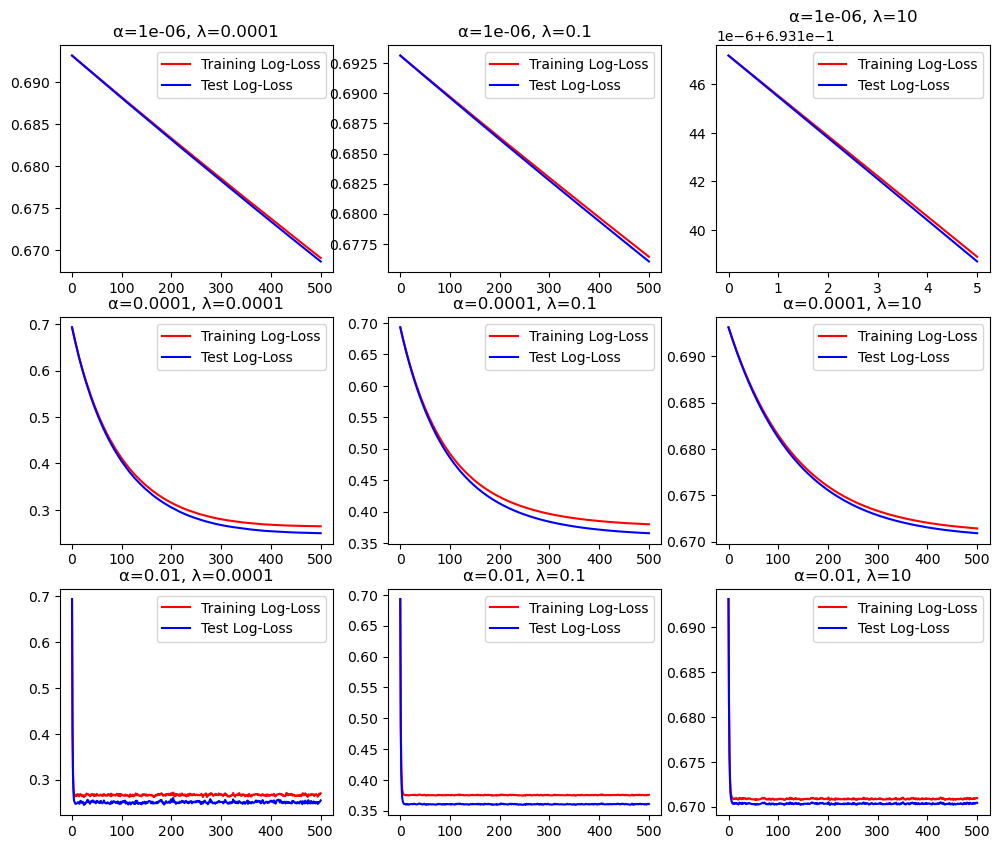

In [322]:
#subplots for each combination of alpha and reg_const
fig, axes = plt.subplots(3, 3, figsize=(12,10))


#alpha1, reg_const1
beta_values, loss_changes = learn_logreg_newton(Xtrain_marketing, ytrain_marketing, reg_const1, alpha1, i_max, eps=eps)
RMSE_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
RMSE_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]



axes[0,0].plot(RMSE_training, label="Training Log-Loss", color="red")
axes[0,0].plot(RMSE_test, label="Test Log-Loss", color="blue")
axes[0,0].set_title(f"α={alpha1}, λ={reg_const1}")
axes[0,0].legend()


#alpha1, reg_const2
beta_values, loss_changes = learn_logreg_newton(Xtrain_marketing, ytrain_marketing, reg_const2, alpha1, i_max, eps=eps)
RMSE_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
RMSE_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[0,1].plot(RMSE_training, label="Training Log-Loss", color="red")
axes[0,1].plot(RMSE_test, label="Test Log-Loss", color="blue")
axes[0,1].set_title(f"α={alpha1}, λ={reg_const2}")
axes[0,1].legend()

#alpha1, reg_const3
beta_values, loss_changes = learn_logreg_newton(Xtrain_marketing, ytrain_marketing, reg_const3, alpha1, i_max, eps=eps)
RMSE_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
RMSE_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[0,2].plot(RMSE_training, label="Training Log-Loss", color="red")
axes[0,2].plot(RMSE_test, label="Test Log-Loss", color="blue")
axes[0,2].set_title(f"α={alpha1}, λ={reg_const3}")
axes[0,2].legend()



#alpha2, reg_const1
beta_values, loss_changes = learn_logreg_newton(Xtrain_marketing, ytrain_marketing, reg_const1, alpha2, i_max, eps=eps)
RMSE_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
RMSE_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[1,0].plot(RMSE_training, label="Training Log-Loss", color="red")
axes[1,0].plot(RMSE_test, label="Test Log-Loss", color="blue")
axes[1,0].set_title(f"α={alpha2}, λ={reg_const1}")
axes[1,0].legend()


#alpha2, reg_const2
beta_values, loss_changes = learn_logreg_newton(Xtrain_marketing, ytrain_marketing, reg_const2, alpha2, i_max, eps=eps)
RMSE_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
RMSE_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[1,1].plot(RMSE_training, label="Training Log-Loss", color="red")
axes[1,1].plot(RMSE_test, label="Test Log-Loss", color="blue")
axes[1,1].set_title(f"α={alpha2}, λ={reg_const2}")
axes[1,1].legend()

#alpha2, reg_const3
beta_values, loss_changes = learn_logreg_newton(Xtrain_marketing, ytrain_marketing, reg_const3, alpha2, i_max, eps=eps)
RMSE_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
RMSE_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[1,2].plot(RMSE_training, label="Training Log-Loss", color="red")
axes[1,2].plot(RMSE_test, label="Test Log-Loss", color="blue")
axes[1,2].set_title(f"α={alpha2}, λ={reg_const3}")
axes[1,2].legend()




#alpha3, reg_const1
beta_values, loss_changes = learn_logreg_newton(Xtrain_marketing, ytrain_marketing, reg_const1, alpha3, i_max, eps=eps)
RMSE_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
RMSE_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[2,0].plot(RMSE_training, label="Training Log-Loss", color="red")
axes[2,0].plot(RMSE_test, label="Test Log-Loss", color="blue")
axes[2,0].set_title(f"α={alpha3}, λ={reg_const1}")
axes[2,0].legend()


#alpha3, reg_const2
beta_values, loss_changes = learn_logreg_newton(Xtrain_marketing, ytrain_marketing, reg_const2, alpha3, i_max, eps=eps)
RMSE_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
RMSE_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[2,1].plot(RMSE_training, label="Training Log-Loss", color="red")
axes[2,1].plot(RMSE_test, label="Test Log-Loss", color="blue")
axes[2,1].set_title(f"α={alpha3}, λ={reg_const2}")
axes[2,1].legend()

#alpha3, reg_const3
beta_values, loss_changes = learn_logreg_newton(Xtrain_marketing, ytrain_marketing, reg_const3, alpha3, i_max, eps=eps)
RMSE_training = [calculate_log_loss(beta, Xtrain_marketing, ytrain_marketing) for beta in beta_values]
RMSE_test = [calculate_log_loss(beta, Xtest_marketing, ytest_marketing) for beta in beta_values]

axes[2,2].plot(RMSE_training, label="Training Log-Loss", color="red")
axes[2,2].plot(RMSE_test, label="Test Log-Loss", color="blue")
axes[2,2].set_title(f"α={alpha3}, λ={reg_const3}")
axes[2,2].legend()




